# 2. Time Series Forecasting using Regularisation

Unlike other cryptocurrencies, Bitcon proved successful in maintaining a strong value in the long-term (River, n.d., para. 3). Additionally, Bitcoin's ability to protect the value of money against the inflationary trend of traditional currencies is another strength that investors are attracted to (River, n.d., para. 4). This might suggest that Bitcoin, similar to Gold, may be the destination of flight to safety for investors in periods of economic
turmoil.

Based on the premise set above:
Bitcoin may have a positive relationship with other Cryptocurrencies, like Ethereum.

Investors prefer Bitcoin over traditional currency denominated assets, such as US Treasuries. As investors' confidence in the Government and the central currency declines, the Treasury yields increase and Bitcoin price may increase as well. Hence, Bitcoin may have a positive relationship with US Treasury yields.

Hardware manufacturers and companies that are involved in the process of Bitcoin mining may have a positive relationship with Bitcoin. This may be a reciprocal causal relationship, as Bitcoin price increases, investment in such companies increases which increases the share price. An increase in these companies' value may indicate trust in Bitcoin's future performance which will determine investors to buy more Bitcoin and increase the price. 
Companies such as Riot Platforms, Marathon Digital Holdings, NVIDIA Corporation, Advanced Micro Devices, Intel Corporation, Argo Blockchain and Sphere 3D Corp. (OpenAI, 2023)

Bitcoin's capability to protect against inflation, may also incentivise investors to buy when the market's favourite stocks are declining in response to predicted economic hardship. Bitcoin may have a negative relationship with the follwoing companies' share price: Apple, Microsoft, Nike, Starbucks (OpenAI, 2023). 

Tesla's recent association with Donald Trump and Trump's support for cryptocurrencies surged the prices of both when Trump became the US President (Jolly, 2024, para. 1, 5, 10). This will affect the normal expected relationship between Tesla's share price and Bitcoin. Hence, Tesla will not be included.

## Extract and Filter Data

In [ ]:
# import libraries and modules to be used in this section
import pandas as pd
import requests
from datetime import datetime, timedelta
import time

In [ ]:
# extract time series

api_key = "..."

# construct the correct API endpoint with maturity specified
url = f'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey={api_key}'

# make the API request
response = requests.get(url)

In [ ]:
# check if the response is successful
if response.status_code == 200:
    data = response.json()

    # extract the correct key for Alpha Vantage
    observations = data.get('data', [])

    if observations:
        df = pd.DataFrame(observations)

        # ensure the expected columns exist
        if 'date' in df.columns and 'value' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            df['value'] = pd.to_numeric(df['value'], errors='coerce')

            # filter last 3 years
            three_years_ago = datetime.now() - timedelta(days=3*365)
            bond_yields = df[df['date'] >= three_years_ago][['date', 'value']]

            print(bond_yields)
        else:
            print("Columns 'date' or 'value' not found in the data.")
    else:
        print("No 'data' returned from API.")
else:
    print("Error fetching data:", response.status_code)

          date  value
0   2025-04-17   4.34
1   2025-04-16   4.29
2   2025-04-15   4.35
3   2025-04-14   4.38
4   2025-04-11   4.48
..         ...    ...
774 2022-04-29   2.89
775 2022-04-28   2.85
776 2022-04-27   2.82
777 2022-04-26   2.77
778 2022-04-25   2.81

[779 rows x 2 columns]


In [ ]:

bond_yields.to_csv("bond_yields.csv")

In [ ]:
# extract stock prices
# companies: Riot Platforms, Marathon Digital Holdings, NVIDIA Corporation,
# Advanced Micro Devices, Intel Corporation, Argo Blockchain and Sphere 3D Corp., 
# Apple, Microsoft, Nike, Starbucks for three years until 21/04/2025.

def get_stock_data(api_key, symbols):
    # create an empty DataFrame to hold all data
    all_data = pd.DataFrame()
    
    for symbol in symbols:
        # construct the Alpha Vantage API URL for daily stock data
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}'
        
        # make the API request
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            
            # debugging: print the full response to check for error messages
            print(f"Response for {symbol}:")
            print(data)
            
            # check for error message in the response
            if "Error Message" in data:
                print(f"Error for {symbol}: {data['Error Message']}")
                continue  # skip this symbol and move to the next
            
            # extract time series data
            timeseries = data.get("Time Series (Daily)", {})
            
            if timeseries:
                # convert to DataFrame
                df = pd.DataFrame.from_dict(timeseries, orient='index')
                df.reset_index(inplace=True)
                df.rename(columns={'index': 'date', '4. close': symbol}, inplace=True)
                
                # convert types
                df['date'] = pd.to_datetime(df['date'])
                df[symbol] = pd.to_numeric(df[symbol], errors='coerce')
                
                # filter data for the last 3 years
                three_years_ago = datetime.now() - timedelta(days=3*365)
                df_filtered = df[df['date'] >= three_years_ago][['date', symbol]]
                
                # merge the data into the all_data DataFrame
                if all_data.empty:
                    all_data = df_filtered
                else:
                    all_data = pd.merge(all_data, df_filtered, on='date', how='outer')
            else:
                print(f"No time series data found for {symbol}.")
        else:
            print(f"Error fetching data for {symbol}: {response.status_code}")
        
        # add a small delay to avoid hitting the API rate limit
        time.sleep(12)  # sleeps for 12 seconds between requests to avoid rate-limiting
    
    # return the complete DataFrame
    return all_data

# example usage:
api_key = "your_api_key"  # replace with API key
pair = [
    "RIOT", "MARA", "NVDA", "AMD", "INTC", "ARBK", "ANY", 
    "AAPL", "MSFT", "NKE", "SBUX", "JPM", "PFE", "MRNA"
]

# get the data and print the result
df = get_stock_data(api_key, pair)
print(df)

In [ ]:
# save DataFrame 
df.to_csv("stock_data.csv")

In [ ]:
# extract new Bitcoin and Ethereum prices for the three years to 21/04/2025

API_KEY = ''

def fetch_crypto_close(symbol, end_date, limit=1095):
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    params = {
        'fsym': symbol,
        'tsym': 'USD',
        'limit': limit,
        'toTs': end_date,
        'api_key': API_KEY
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if data['Response'] != 'Success':
        raise ValueError(f"Error fetching data for {symbol}: {data.get('Message', '')}")
    
    df = pd.DataFrame(data['Data']['Data'])
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('date', inplace=True)
    return df[['close']].rename(columns={'close': f'{symbol}_close'})

# convert date to Unix timestamp
end_timestamp = int(time.mktime(time.strptime('2025-04-21', '%Y-%m-%d'))) +86400

# fetch data
btc_df = fetch_crypto_close('BTC', end_timestamp)
eth_df = fetch_crypto_close('ETH', end_timestamp)

# merge the two DataFrames
crypto_df = pd.concat([btc_df, eth_df], axis=1)

# show first rows
print(crypto_df.head())


In [209]:
crypto_df = crypto_df[::-1]
crypto_df.to_csv("crypto_data.csv")

In [ ]:
# modify data
bond_data = pd.read_csv("bond_yields.csv")
bond_data = bond_data.drop(columns=["Unnamed: 0"])
# convert date to datetime format
bond_data['date'] = pd.to_datetime(bond_data['date'])

In [ ]:
# forward fill missing values

# Step 1: reverse the DataFrame to make it go from oldest to latest
bond_data_rev = bond_data[::-1]

# Step 1: set date as the index
bond_data_rev.set_index('date', inplace=True)

# Step 2: reindex to daily
bond_data_fre = bond_data_rev.asfreq('D')

# Step 3: backward fill the missing values
bond_data_ff = bond_data_fre.ffill()

# Step 4: reverse the dataFrame back to original order (latest to oldest)
bond_data_final = bond_data_ff[::-1]

In [ ]:
# add new dates for 2025 and fill with the last date value of bond yields
# from 17th April 2025

# sort index in ascending order so latest date is at the bottom
bond_data_final.sort_index(inplace=True)

# get the last date and its corresponding row (April 17, 2025)
last_date = bond_data_final.index.max()
last_row = bond_data_final.loc[last_date]

# create new dates from the next day to April 21, 2025
new_dates = pd.date_range(start=last_date + timedelta(days=1), end='2025-04-21')

# duplicate the last row for each new date
new_data = pd.DataFrame([last_row.values] * len(new_dates), index=new_dates, columns=bond_data_final.columns)

# append the new rows
bond_data_final = pd.concat([bond_data_final, new_data])

# final sort
bond_data_final.sort_index(inplace=True)

# reset index if you want date as a column again
bond_data_final.reset_index(inplace=True)
bond_data_final.rename(columns={'index': 'date'}, inplace=True)

bond_data_Final = bond_data_final[::-1]



In [ ]:
# forward filling the missing values in the stock data

stock_data = pd.read_csv("stock_data.csv")
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Step 1: Set date as the index
stock_data.set_index('date', inplace=True)

# Step 2: Reindex to daily
stock_data_fre = stock_data.asfreq('D')

# Step 3: Backward fill the missing values
stock_data_ff = stock_data_fre.ffill()

# Step 4: Reverse the DataFrame to 2025-2022
stock_data_final = stock_data_ff[::-1]

stock_data_final = stock_data_final.drop(columns=["Unnamed: 0"])

In [ ]:
# create new df for crypto data
crypto_data = pd.read_csv("crypto_data.csv")
crypto_data_final = crypto_data[:-3] #extract the last 3 observations

In [ ]:
# merge stock, bond yields, ethereum and bitcoin data into one
# use three years worth of data to 21st April 2025
crypto_Data = crypto_data_final
crypto_Data['date'] = pd.to_datetime(crypto_Data['date'])
crypto_Data.set_index('date', inplace=True)
bond_Ydata = bond_data_Final
bond_Ydata['date'] = pd.to_datetime(bond_Ydata['date'])
bond_Ydata.set_index('date', inplace=True)
stock_Data = stock_data_final

In [217]:
merged = pd.concat([crypto_Data, bond_Ydata, stock_Data], axis=1)

In [ ]:
# change column names
merged.columns.values[0] = 'Bitcoin'
merged.columns.values[1] = 'Ethereum'
merged.columns.values[2] = 'USYields_10year'

## Stationarity Testing

In [ ]:
# check for stationarity using Agumented Dickie Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    results = {}
    for column in df.columns:
        series = df[column].dropna()  # drop NaNs to avoid errors
        result = adfuller(series)
        p_value = result[1]
        is_stationary = p_value < 0.05  # common significance level
        results[column] = {
            'ADF Statistic': result[0],
            'p-value': p_value,
            'Stationary': is_stationary
        }
    return pd.DataFrame(results).T
stationarity_results = check_stationarity(merged)
print(stationarity_results)

                ADF Statistic   p-value Stationary
Bitcoin             -1.277339  0.639475      False
Ethereum            -1.782564  0.389152      False
USYields_10year     -1.144957  0.696815      False
RIOT                -2.987432  0.036085       True
MARA                -2.646249   0.08381      False
NVDA                -2.342275  0.158696      False
AMD                 -1.493505  0.536722      False
INTC                -1.424361  0.570543      False
ARBK                 0.765839  0.991064      False
ANY                  -2.87929   0.04781       True
AAPL                -1.331395   0.61469      False
MSFT                -0.770021   0.82777      False
NKE                 -2.201606  0.205663      False
SBUX                -2.445137    0.1294      False


In [ ]:
# take the first difference of all variables except ANY and RIOT

# create a copy so original data is not modified
df_diff = merged.copy()

# apply differencing to all columns except 'ANY', 'RIOT'
columns_to_diff = merged.columns.difference(['ANY', 'RIOT'])
df_diff[columns_to_diff] = df_diff[columns_to_diff].diff()

# optional: drop the first row since diff() creates NaNs
df_diff = df_diff.dropna()


In [ ]:
# check for stationarity on the differenced data set
stationarity_results = check_stationarity(df_diff)
print(stationarity_results)

                ADF Statistic   p-value Stationary
Bitcoin             -8.246093       0.0       True
Ethereum           -17.896213       0.0       True
USYields_10year    -24.727291       0.0       True
RIOT                -2.952223  0.039604       True
MARA                -7.102435       0.0       True
NVDA                -32.98939       0.0       True
AMD                    -11.16       0.0       True
INTC               -32.917757       0.0       True
ARBK               -12.807772       0.0       True
ANY                   -2.8787  0.047882       True
AAPL                -33.23782       0.0       True
MSFT               -25.207738       0.0       True
NKE                -33.008647       0.0       True
SBUX                -33.14295       0.0       True


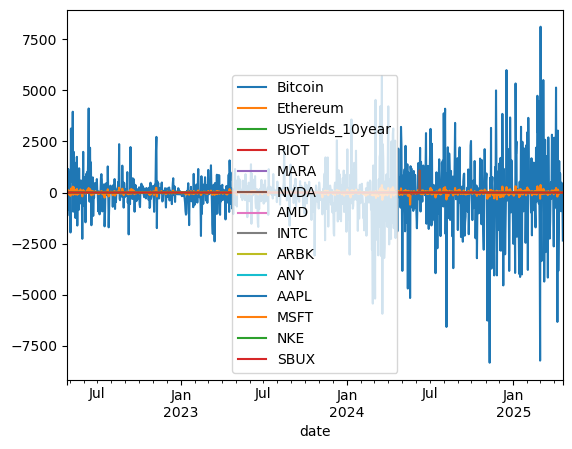

In [ ]:
# plot the data set
df_diff.plot()
plt.show()

## Create lags of order 1 and Scale data

In [ ]:
# create lag values of the series

def create_lagged_df(df: pd.DataFrame, lag: int = 1) -> pd.DataFrame:
    lagged = df.shift(lag)
    lagged.columns = [f"{col}_lag{lag}" for col in df.columns]
    return lagged

In [ ]:
# add bitcoin - target variable to the same DataFrame for scaling
lagged_data = create_lagged_df(df_diff, 1).dropna()
lagged_data['Bitcoin'] = df_diff['Bitcoin']

In [ ]:
# scale the lagged data
from sklearn.preprocessing import StandardScaler
st_sc = StandardScaler()
scaled_merged = pd.DataFrame(st_sc.fit_transform(lagged_data), index=lagged_data.index, columns=lagged_data.columns)

## Regularisation with Elastic Net Cross Validation using TimeSeriesSplit 

In [ ]:
# Mean Squared Error (MSE) was minimised using the number of splits and the test szie given by the trial and error test below.
# The specific number the splits and the test size obtained will provide the best fit. 
# This generates the closest prdictions to the actual values.

from sklearn.model_selection import TimeSeriesSplit
t_splt = TimeSeriesSplit(n_splits=8, test_size=68)

from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(cv=t_splt, random_state=0)
x = scaled_merged.iloc[:, :-1]
y = scaled_merged.iloc[:, -1]
regr.fit(x, y)

# show coefficients left after appying regularisation 
feature_names = x.columns
for feature, coef in zip(feature_names, regr.coef_):
    print(f"{feature}: {coef}")

# analyse performance
print(regr.alpha_)

print(regr.l1_ratio_)

# get mean squared error of the best alpha
import numpy as np

# mean MSE for each alpha across folds
mean_mse = regr.mse_path_.mean(axis=1)

# find the best alpha (the one ElasticNetCV selected)
best_alpha_idx = np.where(regr.alphas_ == regr.alpha_)[0][0]

# retrieve the MSE for that alpha
best_mse = mean_mse[best_alpha_idx]

print(f"Best MSE (mean across folds): {best_mse}")

Bitcoin_lag1: -0.0
Ethereum_lag1: -0.0
USYields_10year_lag1: 0.0
RIOT_lag1: -0.0
MARA_lag1: 0.0
NVDA_lag1: -0.0
AMD_lag1: 0.0
INTC_lag1: -0.0
ARBK_lag1: -0.0
ANY_lag1: -0.0
AAPL_lag1: -0.0
MSFT_lag1: 0.0
NKE_lag1: 0.0
SBUX_lag1: 0.0
0.18120635974991567
0.5
Best MSE (mean across folds): 0.24550683700126208


Regularisation droped all independent vraiables when using the combination of splits and test size that produces the most optimal MSE. This means that the variables do not have significant explanatory power to predict the price of bitcoin. Trading off some accuracy in prediction, that is by increasing MSE, some coefficients have a small impact. Increasing the error to obtain impactfull coefficients does not make sense statistically, as the smallet MSE is preffered.

## Finding lowest MSE using Trial and Error 

Splits: 2, Test Size: 30 → MSE: 0.8669
Splits: 2, Test Size: 32 → MSE: 0.8164
Splits: 2, Test Size: 34 → MSE: 0.7719
Splits: 2, Test Size: 36 → MSE: 0.7354
Splits: 2, Test Size: 38 → MSE: 0.7072
Splits: 2, Test Size: 40 → MSE: 0.6847
Splits: 2, Test Size: 42 → MSE: 0.6680
Splits: 2, Test Size: 44 → MSE: 0.6445
Splits: 2, Test Size: 46 → MSE: 0.6253
Splits: 2, Test Size: 48 → MSE: 0.6182
Splits: 2, Test Size: 50 → MSE: 0.5963
Splits: 2, Test Size: 52 → MSE: 0.5777
Splits: 2, Test Size: 54 → MSE: 0.5626
Splits: 2, Test Size: 56 → MSE: 0.5424
Splits: 2, Test Size: 58 → MSE: 0.5502
Splits: 2, Test Size: 60 → MSE: 0.5317
Splits: 2, Test Size: 62 → MSE: 0.5218
Splits: 2, Test Size: 64 → MSE: 0.5086
Splits: 2, Test Size: 66 → MSE: 0.4937
Splits: 2, Test Size: 68 → MSE: 0.4853
Splits: 2, Test Size: 70 → MSE: 0.4855
Splits: 2, Test Size: 72 → MSE: 0.4892
Splits: 2, Test Size: 74 → MSE: 0.4798
Splits: 2, Test Size: 76 → MSE: 0.4711
Splits: 2, Test Size: 78 → MSE: 0.4606
Splits: 2, Test Size: 80 

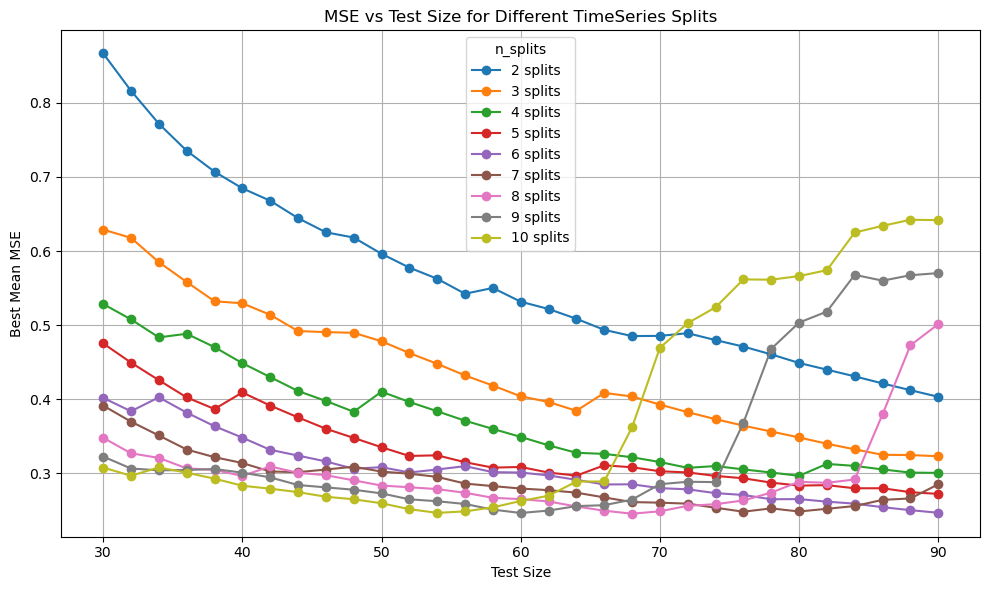

In [ ]:
# The most optimal MSE was obtaiend using a combination of regularisation, time series split logic, and gradient descent (trial and error).
# This analysis also found the number of splits and the test size that minimses the MSE.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

# scaled and merged data
x = scaled_merged.iloc[:, :-1]
y = scaled_merged.iloc[:, -1]
n_samples = len(x)

# flexible ranges
split_range = range(2, 11)            # 2 to 10 splits
test_size_range = range(30, 91, 2)    # test sizes from 30 to 90, step 2

# variables to track the best result
best_mse = float('inf')  # initialise to a large number
best_n_splits = None
best_test_size = None

# store the results for plotting
results = []

# iterate over all combinations of splits and test size
for n_splits in split_range:
    for test_size in test_size_range:
        if n_splits * test_size >= n_samples:
            continue  # skip invalid configurations

        try:
            # perform TimeSeries split
            tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
            model = ElasticNetCV(cv=tscv, random_state=0)
            model.fit(x, y)

            # mean MSE across all folds
            mean_mse = model.mse_path_.mean(axis=1)
            best_alpha_idx = np.where(model.alphas_ == model.alpha_)[0][0]
            best_mse_candidate = mean_mse[best_alpha_idx]

            # store the result
            results.append((n_splits, test_size, best_mse_candidate))
            print(f"Splits: {n_splits}, Test Size: {test_size} → MSE: {best_mse_candidate:.4f}")
            
            # check if the current MSE is the smallest one
            if best_mse_candidate < best_mse:
                best_mse = best_mse_candidate
                best_n_splits = n_splits
                best_test_size = test_size

        except Exception as e:
            print(f"Failed for splits={n_splits}, test_size={test_size}: {e}")

# after loop, print the best MSE and corresponding splits/test size
print(f"\nBest MSE: {best_mse:.4f}")
print(f"Best number of splits: {best_n_splits}")
print(f"Best test size: {best_test_size}")

# plot the results
fig = plt.figure(figsize=(10, 6))
for n_splits in sorted(set(r[0] for r in results)):
    filtered = [r for r in results if r[0] == n_splits]
    test_sizes = [r[1] for r in filtered]
    mses = [r[2] for r in filtered]
    plt.plot(test_sizes, mses, marker='o', label=f"{n_splits} splits")

plt.xlabel("Test Size")
plt.ylabel("Best Mean MSE")
plt.title("MSE vs Test Size for Different TimeSeries Splits")
plt.legend(title="n_splits")
plt.grid(True)
plt.tight_layout()
plt.show()


## Producing one Time Series Forecast

In [180]:
print(regr.intercept_)

-1.953829704198259e-17


In [ ]:
# predicting the price of bitcoin for the next period

print(regr.predict([x.iloc[0].values]))

# The prediction will equal the intercept as all features have been been reduced to 0.
# The variables from the model do not produce reliable forecasts for the price of Bitcoin.

[-1.9538297e-17]


c:\Users\const\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


In [ ]:
# pred_scaled is the model's output after prediction
pred_scaled = regr.predict([x.iloc[0].values])[0]

# get the mean and standard deviation from the StandardScaler
mean = st_sc.mean_[14]  # the mean of the feature
std_dev = st_sc.scale_[14]  # the standard deviation of the feature

# manually undo the scaling of the predicted value
pred_actual = (pred_scaled * std_dev) + mean

print(f"Predicted differenced price for 2025-04-20: {pred_actual}")

Predicted differenced price for 2025-04-20: -40.99873510540792


c:\Users\const\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


In [ ]:
# undoing the differencing process by adding back the difference in price 
# on the 21st of April 2025

# get the original price for the previous day (April 21st, which is the first row in the reverse-order data)
price_on_21st = merged.loc['2025-04-21', 'Bitcoin']

# calculate the predicted actual price for the 20th by undoing the differencing
predicted_actual_price_20th = pred_actual + price_on_21st

print(f"Predicted Price for 2025-04-20: {predicted_actual_price_20th}, and actual value on 2025-04-20: {price_on_21st}.")

Predicted Price for 2025-04-20: 87474.57126489459, and actual value on 2025-04-20: 87515.57.


References:

Jolly, J. (2024, November 11). Bitcoin price tops $87,000 for first time amid ‘Trump pump’. The Guardian. https://www.theguardian.com/technology/2024/nov/11/bitcoin-price-tops-81000-trump-cryptocurrencies

River. (n.d.). Why people invest in Bitcoin. https://river.com/learn/why-people-invest-in-bitcoin/ (Accessed April 22, 2025)

University of Exeter. (n.d.). Gradient Descent (GD) More General.ipynb [Jupyter Notebook]. University of Exeter.

OpenAI. (2023). ChatGPT (ChatGPT-4, March 14, 2023) [AI Language Model]. https://chat.openai.com/auth/login